# <a id='toc1_'></a>[COVID-19 Prediction](#toc0_)

Sam Celarek  
Data Science   
scelarek@gmail.com  

June 4th, 2023


**Table of contents**<a id='toc0_'></a>    
- [COVID-19 Prediction](#toc1_)    
- [1. Introduction](#toc2_)    
  - [1.1. Key Questions](#toc2_1_)    
- [2. Setup and Data Collection](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[1. Introduction](#toc0_)

In this project, we will perform a set of analyses on the relationship between different variables and the mosquito number, as well as the probability of finding West Nile Virus (WNV) at any particular time and location. 


## <a id='toc2_1_'></a>[1.1. Key Questions](#toc0_)

## <a id='toc2_1_'></a>[1.2. Data Sources and Methods](#toc0_)


# <a id='toc3_'></a>[2. Setup and Data Collection](#toc0_)

We will be utilizing the cleaned mosquito tracking data from the city of Chicago, Illinois, spanning from 2008 to 2019 provided [here](link_to_dataset). This section will include the necessary libraries and modules for the analysis, as well as the data preparation steps.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import datetime as dt
from functools import reduce
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm


# Viz libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

%matplotlib inline
pd.plotting.register_matplotlib_converters()

# ML libraries
import scipy as sci
import sympy as sym
import sklearn as sk

# Other libraries
# import re
# from collections import defaultdict
# from datetime import timedelta
# from dateutil.relativedelta import relativedelta
# import functools
# from IPython.display import display, Markdown
# import math
# import os
# os.environ["PYTHONHASHSEED"] = "123"
# from pprint import pprint

In [2]:
import covsirphy as cs

print(f"Python version: {sys.version}")

print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Matplotlib version: {mpl.__version__}")
# print(f"Scipy version: {scipy.__version__}")
# print(f"Statsmodels version: {sm.__version__}")
print(f"SKLearn version: {sk.__version__}")
print(f"Covsirphy version: {cs.__version__}")


Python version: 3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
Pandas version: 2.0.2
Numpy version: 1.23.4
Seaborn version: 0.12.1
Matplotlib version: 3.6.2
SKLearn version: 1.2.2
Covsirphy version: 3.0.0


In [3]:
# initialize styling params
np.random.seed(123)
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)
pd.set_option("display.max_colwidth", 1000)
cs.config.logger(level=2)

In [4]:
folder_holder = "C://Users/Samsickle/Documents/Universal_Code_Bank/BrainStation_Capstone/Data/"


# # # time series data
epid_df = pd.read_csv(f'{folder_holder}epidemiology.csv') # 1
hospitalizations_df = pd.read_csv(f'{folder_holder}hospitalizations.csv') # 2
vac_df = pd.read_csv(f'{folder_holder}vaccinations.csv') # 3
mobility_df = pd.read_csv(f'{folder_holder}mobility.csv') # 4
gov_response_df = pd.read_csv(f'{folder_holder}oxford-government-response.csv') # 5
weather_df = pd.read_csv(f'{folder_holder}weather.csv') # 6

timeland_df = [epid_df, hospitalizations_df, mobility_df, vac_df, gov_response_df, weather_df]





In [12]:
eng = cs.DataEngineer()
eng.download(databases=["covid19dh", "owid", "wpp"])
eng.all().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312029 entries, 0 to 312028
Data columns (total 27 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ISO3                                 312029 non-null  category      
 1   Province                             312029 non-null  category      
 2   City                                 312029 non-null  category      
 3   Date                                 312029 non-null  datetime64[ns]
 4   Cancel_events                        197480 non-null  Float64       
 5   Confirmed                            237858 non-null  Float64       
 6   Contact_tracing                      197507 non-null  Float64       
 7   Country                              270982 non-null  string        
 8   Fatal                                220655 non-null  Float64       
 9   Gatherings_restrictions              197480 non-null  Float64       
 

In [13]:
date_range = ('2020-01-01', '2022-09-15')
eng.clean(kinds=["resample"], date_range=date_range)
eng.clean()
eng.all().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231295 entries, 0 to 231294
Data columns (total 27 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ISO3                                 231295 non-null  category      
 1   Province                             231295 non-null  category      
 2   City                                 231295 non-null  category      
 3   Date                                 231295 non-null  datetime64[ns]
 4   Cancel_events                        231295 non-null  Float64       
 5   Confirmed                            231295 non-null  Float64       
 6   Contact_tracing                      231295 non-null  Float64       
 7   Country                              231295 non-null  object        
 8   Fatal                                231295 non-null  Float64       
 9   Gatherings_restrictions              231295 non-null  Float64       
 

In [14]:
main_variables = ["Population", "Susceptible", "Confirmed", "Infected", "Fatal", "Recovered"]
eng.transform()
eng.all(variables=main_variables).tail()



,ISO3,Province,City,Date,Population,Susceptible,Confirmed,Infected,Fatal,Recovered
231290,ZWE,-,-,2022-09-11,14439018.0,14182148.0,256870.0,168280.0,5596.0,82994.0
231291,ZWE,-,-,2022-09-12,14439018.0,14182130.0,256888.0,168298.0,5596.0,82994.0
231292,ZWE,-,-,2022-09-13,14439018.0,14182114.0,256904.0,168314.0,5596.0,82994.0
231293,ZWE,-,-,2022-09-14,14439018.0,14182079.0,256939.0,168349.0,5596.0,82994.0
231294,ZWE,-,-,2022-09-15,14439018.0,14182079.0,256939.0,168349.0,5596.0,82994.0


In [15]:

eng.diff(column="Confirmed", suffix="_diff", freq="D")
eng.add(columns=["Fatal", "Recovered"])
# Division
eng.div(numerator="Confirmed", denominator="Tests", new="Positive_rate")
# Assignment of new a new column
eng.all(variables=["Tests", "Confirmed"]).tail()


,ISO3,Province,City,Date,Tests,Confirmed,Positive_rate_%
231290,ZWE,-,-,2022-09-11,2379907.0,256870.0,10.793279
231291,ZWE,-,-,2022-09-12,2379907.0,256888.0,10.794035
231292,ZWE,-,-,2022-09-13,2379907.0,256904.0,10.794708
231293,ZWE,-,-,2022-09-14,2379907.0,256939.0,10.796178
231294,ZWE,-,-,2022-09-15,2379907.0,256939.0,10.796178


In [29]:

with_df, status, status_dict = eng.subset(geo="USA", complement=True)
print(f"{status}\n")
print(status_dict)
with_df.info()
with_df.head()

monotonic increasing complemented confirmed data and 
monotonic increasing complemented fatal data and 
fully complemented recovered data

{'Monotonic_confirmed': True, 'Monotonic_fatal': True, 'Monotonic_recovered': False, 'Full_recovered': True, 'Partial_recovered': False}
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 987 entries, 2020-01-03 to 2022-09-15
Data columns (total 30 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Cancel_events                                               987 non-null    Float64
 1   Confirmed_diff                                              987 non-null    Float64
 2   Contact_tracing                                             987 non-null    Float64
 3   Fatal+Recovered                                             987 non-null    Int64  
 4   Gatherings_restrictions                                     9

,Cancel_events,Confirmed_diff,Contact_tracing,Fatal+Recovered,Gatherings_restrictions,Infected,Information_campaigns,Internal_movement_restrictions,International_movement_restrictions,Population,...,Vaccinated_once,Vaccinations,Vaccinations_boosters,Workplace_closing,Confirmed,Fatal,Recovered,Country_United States,Product_0,"Product_Johnson&Johnson, Moderna, Novavax, Pfizer/BioNTech"
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,326687501.0,...,0.0,0.0,0.0,0.0,0,0,0,1,1,0
2020-01-04,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,326687501.0,...,0.0,0.0,0.0,0.0,0,0,0,1,1,0
2020-01-05,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,326687501.0,...,0.0,0.0,0.0,0.0,0,0,0,1,1,0
2020-01-06,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,326687501.0,...,0.0,0.0,0.0,0.0,0,0,0,1,1,0
2020-01-07,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,326687501.0,...,0.0,0.0,0.0,0.0,0,0,0,1,1,0


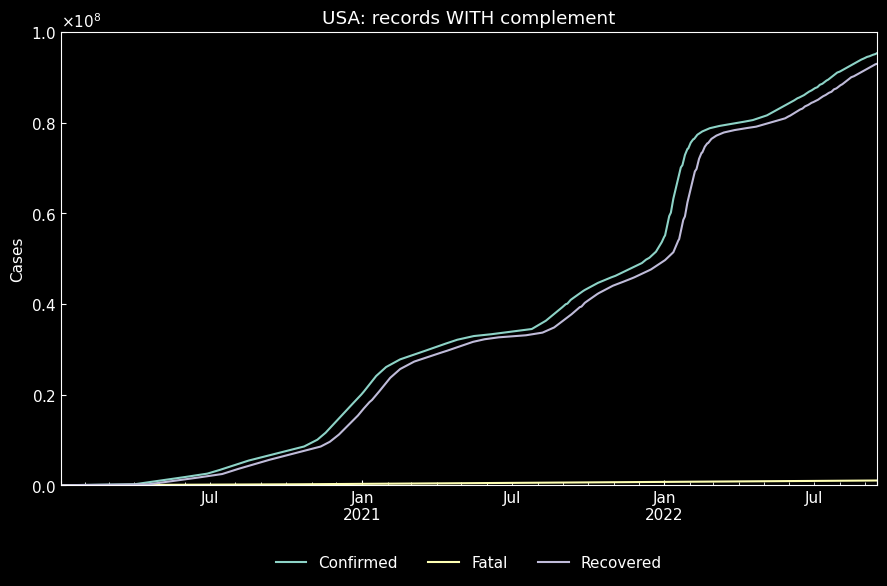

In [30]:
cs.line_plot(with_df[["Confirmed", "Fatal", "Recovered"]], title="USA: records WITH complement")

In [26]:
with_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 987 entries, 2020-01-03 to 2022-09-15
Data columns (total 30 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Cancel_events                                               987 non-null    Float64
 1   Confirmed_diff                                              987 non-null    Float64
 2   Contact_tracing                                             987 non-null    Float64
 3   Fatal+Recovered                                             987 non-null    Int64  
 4   Gatherings_restrictions                                     987 non-null    Float64
 5   Infected                                                    987 non-null    Int64  
 6   Information_campaigns                                       987 non-null    Float64
 7   Internal_movement_restrictions                              987 non-nu

In [18]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Filter rows based on column: 'location_key'
    # df = df[df['location_key'].str.contains(r"^(US|CA|DE|GB|FR|JP|AU|BR|ZA|IN)$", na=False)]
    df = df[df['location_key'].str.contains(r"^(US)$", na=False)] # only the us to start

    # Change column type to datetime64[ns] for column: 'date'
    try:
        df = df.astype({'date': 'datetime64[ns]'})
    except:
        pass
    # Change column type to category for column: 'location_key'
    df = df.astype({'location_key': 'category'})
    return df


time_series_dfs = list(map(clean_data, timeland_df))

# # Assume dfs is your list of dataframes
time_series_dfs = reduce(lambda left,right: pd.merge(left,right,on=['location_key', 'date'], how='left'), time_series_dfs).copy()


In [31]:
snr_act = cs.ODEScenario.auto_build(geo="USA", model=cs.SIRFModel, complement=True)

snr_act

c:\ProgramData\Anaconda3\lib\site-packages\covsirphy\dynamics\_trend.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_df[self.num2str(i)] = self._linear_f(phase_df[r], a=param[0], b=param[1])
c:\ProgramData\Anaconda3\lib\site-packages\covsirphy\dynamics\_trend.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_df[self.num2str(i)] = self._linear_f(phase_df[r], a=param[0], b=param[1])
c:\ProgramData\Anaconda3\lib\site-packages\covsirphy\dynamics\_trend.py:98: PerformanceWarning: DataFrame is highly fragmented.  This 

  0%|          | 0/114 [00:00<?, ?it/s]

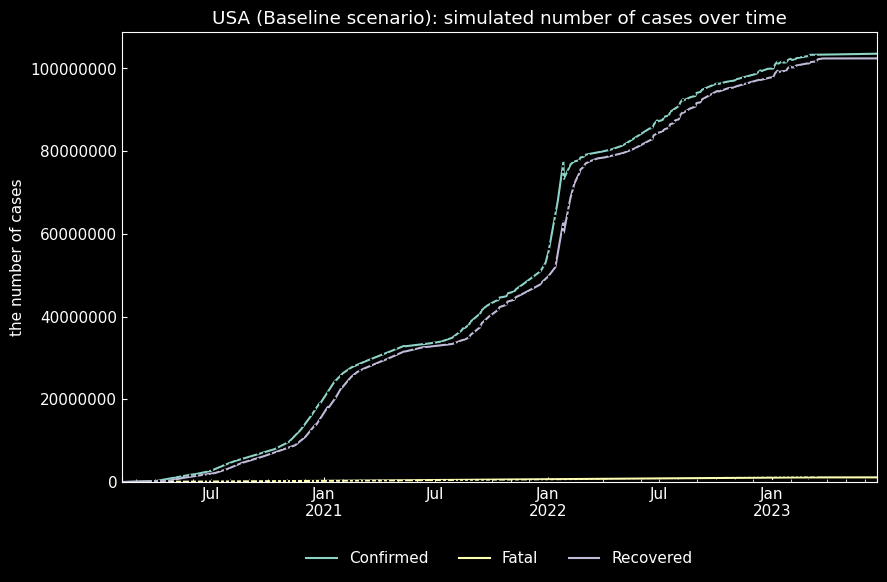

In [32]:
snr_act.simulate(name="Baseline");

,Start,End,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
Phase,,,,,,,,,,,
0th,2020-02-07,2020-03-28,15.0,0.000628,0.00008,0.002538,0.000089,0.001,208,7,188
1st,2020-03-29,2020-04-07,11.65,0.005696,0.000085,0.002196,0.000103,0.006,197,8,162
2nd,2020-04-08,2020-04-20,1.6,0.003498,0.000081,0.001157,0.000637,0.003,205,14,26
3rd,2020-04-21,2020-05-02,0.99,0.000795,0.00008,0.00115,0.00108,0.001,209,14,15
4th,2020-05-03,2020-05-14,0.81,0.001122,0.000069,0.00087,0.000999,0.001,241,19,17
...,...,...,...,...,...,...,...,...,...,...,...
109th,2023-02-07,2023-02-13,1.52,0.001784,0.000004,0.00163,0.001069,0.002,4277,10,16
110th,2023-02-14,2023-02-20,1.81,0.02201,0.000007,0.000884,0.00047,0.022,2453,19,35
111th,2023-02-21,2023-03-01,3.98,0.19033,0.000014,0.000456,0.000079,0.19,1185,37,212


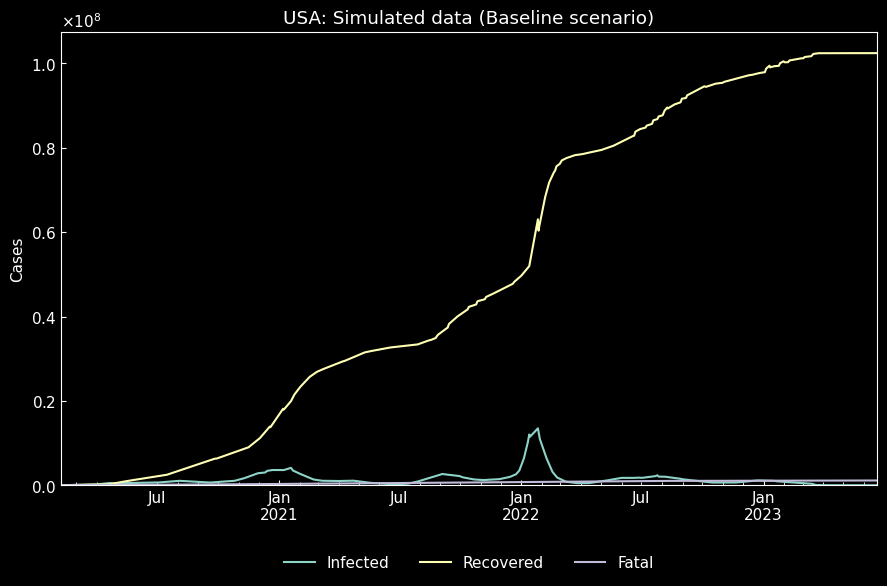

In [33]:
dyn_act = snr_act.to_dynamics(name="Baseline")
# Show summary
display(dyn_act.summary())
# Simulation
dyn_act_df = dyn_act.simulate(model_specific=False)
cs.line_plot(
    dyn_act_df.drop("Susceptible", axis=1), "USA: Simulated data (Baseline scenario)")

<AxesSubplot: xlabel='date'>

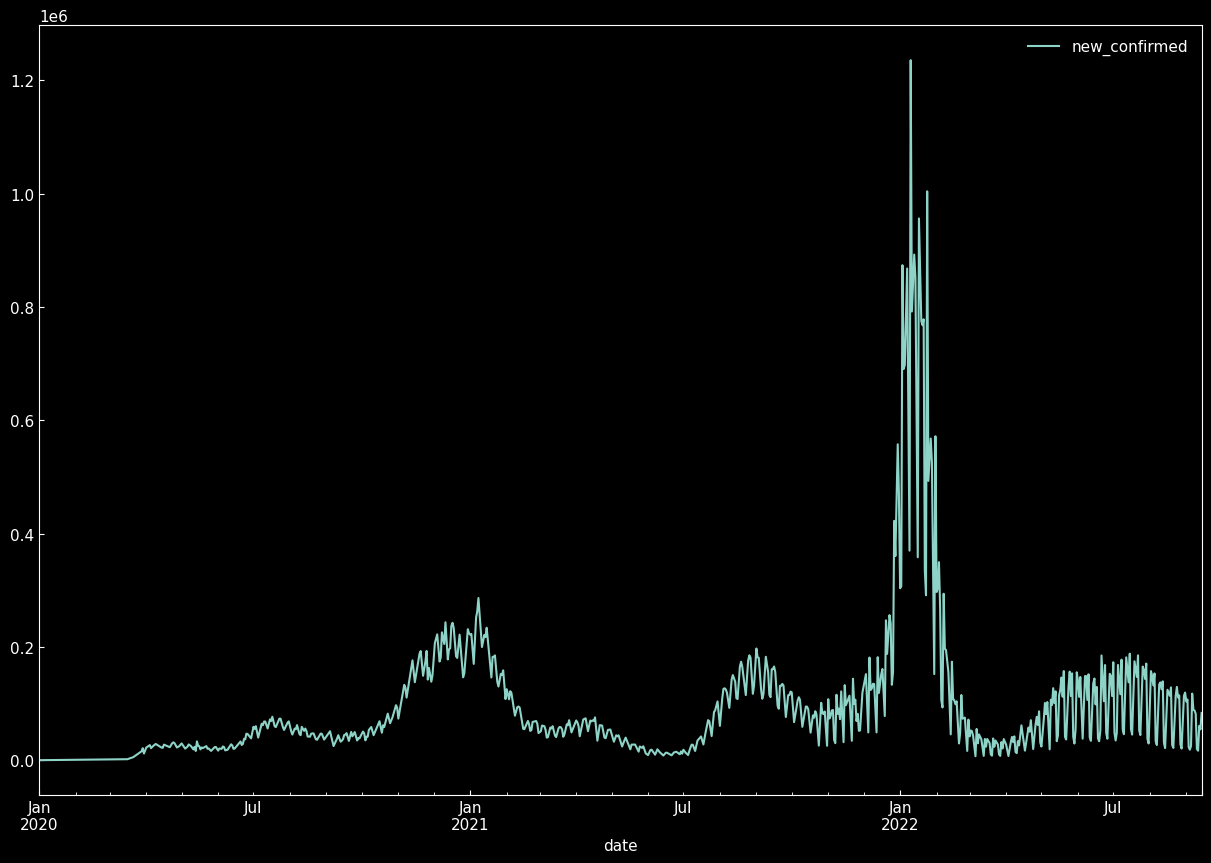

In [19]:
# time_series_dfs.to_pickle('../Data/time_series_dfs.pkl')

time_series_dfs = pd.read_pickle('../Data/time_series_dfs.pkl')


# time_series_dfs_line_plot = time_series_dfs.dropna(subset='new_confirmed').copy()
# # sns.lineplot(data = time_series_dfs_line_plot, x = 'date', y = 'new_confirmed')

# time_series_dfs_line_plot.plot(x = 'date', y = 'new_confirmed', figsize = (15, 10))

# # add lines for each column
# fig = px.line(time_series_dfs_line_plot, x=air_traffic.index, y=air_traffic.columns,)

# # axis labels and title
# fig.update_layout(
#     yaxis_title="Passenger-miles (billions)", 
#     legend_title="", 
#     title="Daily air travel from 1979 to 2002"
# )

# # activate slider
# fig.update_xaxes(rangeslider_visible=True)

# fig.show()

In [20]:
# folder_holder = "C://Users/Samsickle/Documents/BrainStation_Capstone/Data/"
# # C:\Users\Samsickle\Documents\BrainStation_Capstone\Data

# # # # time series data
# # hospitalizations_df = pd.read_csv(f'{folder_holder}hospitalizations.csv') # 2
# # mobility_df = pd.read_csv(f'{folder_holder}mobility.csv') # 4
# # gov_response_df = pd.read_csv(f'{folder_holder}oxford-government-response.csv') # 5
# # weather_df = pd.read_csv(f'{folder_holder}weather.csv') # 6

# epid_df = pd.read_csv(f'{folder_holder}epidemiology.csv') # 1
# # vac_df = pd.read_csv(f'{folder_holder}vaccinations.csv') # 3


In [21]:
# epid_df.sample(5)

Data Wireframe:

1. Date and Location:
    - 'date' - the day of the observations
    - 'location_key' - the country of the observations. I choose ten countries of interest in different regions

United States (US)  
Canada (CA)  
Germany (DE)  
United Kingdom (GB)  
France (FR)  
Japan (JP)  
Australia (AU)  
Brazil (BR)  
South Africa (ZA)  
India (IN)  
These countries are often used as indicators for their respective regions due to their significant economic influence, political stability, and comprehensive data collection practices.

2. COVID-19 Statistics:
    - 'new_confirmed' (New Positive Cases) - the number of new confirmed cases of COVID-19, this includes some negative numbers to account for data corrections in the previous days, however because these numbers are aggregated accross a whole country, the negative numbers are often very small and remain positive
    - 'new_deceased' (New Deaths) - the number of new deaths due to COVID-19 also shares the negative number problem
    - 'new_hospitalized_patients' (New Hospitalizations) 

3. Mobility Data:
    - 'mobility_retail_and_recreation'
    - 'mobility_grocery_and_pharmacy'
    - 'mobility_parks'
    - 'mobility_transit_stations'
    - 'mobility_workplaces'
    - 'mobility_residential'



4. Vaccination Data:
    - 'new_persons_vaccinated'
    - 'cumulative_persons_vaccinated'
    - 'new_persons_fully_vaccinated'
    - 'cumulative_persons_fully_vaccinated'
    - 'new_vaccine_doses_administered'
    - 'cumulative_vaccine_doses_administered'

5. Policy Measures:
    - 'school_closing'
    - 'workplace_closing'
    - 'cancel_public_events'
    - 'restrictions_on_gatherings'
    - 'public_transport_closing'
    - 'stay_at_home_requirements'
    - 'restrictions_on_internal_movement'
    - 'international_travel_controls'
    - 'income_support'
    - 'debt_relief'
    - 'fiscal_measures'
    - 'international_support'
    - 'public_information_campaigns'
    - 'testing_policy'
    - 'contact_tracing'
    - 'emergency_investment_in_healthcare'
    - 'investment_in_vaccines'
    - 'facial_coverings'
    - 'vaccination_policy'
    - 'stringency_index'

6. Weather Data:
    - 'average_temperature_celsius'
    - 'minimum_temperature_celsius'
    - 'maximum_temperature_celsius'
    - 'rainfall_mm'
    - 'snowfall_mm'
    - 'dew_point'
    - 'relative_humidity'


In [22]:
# location dfs
geography_df = pd.read_csv(f'{folder_holder}geography.csv') #1
health_df = pd.read_csv(f'{folder_holder}health.csv') #2
demographics_df = pd.read_csv(f'{folder_holder}demographics.csv') #3
economics_df = pd.read_csv(f'{folder_holder}economy.csv') #4


locationland_df = [geography_df, health_df, demographics_df, economics_df]

In [23]:
location_df = list(map(clean_data, locationland_df))

# Assume dfs is your list of dataframes
location_df = reduce(lambda left,right: pd.merge(left,right,on='location_key', how='left'), location_df).copy()

location_df


,location_key,openstreetmap_id,latitude,longitude,elevation_m,area_sq_km,area_rural_sq_km,area_urban_sq_km,life_expectancy,smoking_prevalence,...,population_age_20_29,population_age_30_39,population_age_40_49,population_age_50_59,population_age_60_69,population_age_70_79,population_age_80_and_older,gdp_usd,gdp_per_capita_usd,human_capital_index
0,US,148838.0,39.828175,-98.5795,NaN,9831510.0,8549545.0,802053.0,78.539024,21.8,...,46094075.0,44668270.0,40348397.0,42120077.0,38488170.0,24082597.0,13147182.0,2.137442e+13,65118.0,0.762


In [24]:

location_df.to_pickle('../Data/location_df.pkl')
location_df = pd.read_pickle('../Data/location_df.pkl')

location_df.sample(3)

ValueError: Cannot take a larger sample than population when 'replace=False'

This dataframe provides a comprehensive snapshot of COVID-19 data, mobility metrics, government restrictions, and weather conditions for specific locations on specific dates. Here's a brief overview of the columns:

1. `Entry ID`: A unique identifier for each row in the dataframe.
2. `Date`: The date for the day on which the data was recorded.
3. `Location Key`: A code representing the location (10 different countries in total) for which the data is reported.

4. `New Confirmed`: The number of new confirmed COVID-19 cases on the given date.
5. `New Deceased`: The number of new COVID-19 related deaths on the given date.
6. `New Recovered`: The number of new recoveries from COVID-19 on the given date.
7. `New Tested`: The number of new COVID-19 tests conducted on the given date.

8. `New Hospitalizations`: The number of new hospitalizations due to COVID-19 on the given date.
9. `Current Hospitalizations`: The total number of current hospitalizations due to COVID-19 on the given date.

10. `New Fully Vaccinated (29+ other Vaccination Columns)`: The number of new fully vaccinated individuals on the given date. There are 29 other columns related to vaccination data here too.

11. `Retail and Recreation Mobility (5+ other Mobility Metrics)`: A measure of mobility in retail and recreation spaces, along with 5 other columns related to different aspects of mobility.

12. `School Closing (19+ other Government Restrictions)`: A measure indicating whether schools were closed on the given date, along with 19 other columns related to different government restrictions.

13. `Average Temp (6+ Other Weather Columns)`: The average temperature on the given date, along with 6 other columns related to different weather conditions.

In total there are 9880 and 82 rows for 6.3mbs of data. The main way I could increase or decrease the size of the dataset would be to include more countries, regions, or counties in the analysis. For now this is my starter df.
